<a href="https://colab.research.google.com/github/deep-diver/segformer-tf-transformers/blob/main/notebooks/TFSegFormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial notebook to run TensorFlow based `SegFormer` model in 🤗 `transformers`

This notebook demonstrates how to use TensorFlow based `SegFormer` model from 🤗 `transformers` package. There is another [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) which shows the same thing but using PyTorch based `SegFormer` model instead. Both usages are similart, but there are some slightly differeces. So please read this notebook if you are a TensorFlow user.

# Get logits from the model

## Install `transformers` from source

As of 07/01/2022, the TensorFlow based SegFormer model is under Pull Request, so you should install `transformers` from source. In particular, you should checkout `tf-segformer` branch from [this repository](https://github.com/sayakpaul/transformers/tree/tf-segformer). The instruction how to install it from source is as follows. However, once the Pull Request is merged, you will no longer need to install `transformers` from source, and this notice will be removed.

!pip install git+https://github.com/sayakpaul/transformers.git@tf-segformer

## Ohter libraries to install besides `transformers`

!pip install datasets==2.3.2
!pip install numpy==1.23.0
!pip install pillow==9.1.1
!pip install matplotlib==3.5.2
!pip install tensorflow==2.9.0

## Import packages

- `SegformerFeatureExtractor` is a feature extractor. This is a common module across TensorFlow and PyTorch based models.
- `TFSegformerForSemanticSegmentation` defines a semantic segmentation model and related libraries implemented in TensorFlow. 

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from transformers import SegformerFeatureExtractor, TFSegformerForSemanticSegmentation
from datasets import load_dataset



## Take an example image and its ground truth segmentation map from `ADE20k`

In [ ]:

ds = load_dataset("hf-internal-testing/fixtures_ade20k", split="test")
image = Image.open(ds[0]["file"])
segmentation_map = Image.open(ds[1]["file"])

No config specified, defaulting to: fixtures_ade20k/image
Reusing dataset fixtures_ade20k (/home/codespace/.cache/huggingface/datasets/hf-internal-testing___fixtures_ade20k/image/1.9.0/dbb69c3ff2da9a2dcc2de41e8d7ab6543402914292e3d29a4f9701bef817e7db)


## Load pretrained extractor and model into TensorFlow based implementation

note that `TFSegformerForSemanticSegmentation.from_pretrained` is using `from_pt` argument. It means the TensorFlow based model is initialized with the weights from PyTorch based model. This argument will be removed once the PR of TensorFlow based `SegFormer` is merged. 

In [ ]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = TFSegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSegformerForSemanticSegmentation: ['decode_head.batch_norm.num_batches_tracked']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFSegformerForSemanticSegmentation were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


## Get logits from the output of the model with the given image

note that `feature_extractor` has `return_tensors="tf"` to return the result as TensorFlow `Tensor`

In [ ]:
inputs = feature_extractor(images=image, return_tensors="tf")
outputs = model(**inputs, training=False)
logits = outputs.logits

# Visualize the predicted segmentation map on the image

The ADE20k dataset consists of 150 classes, so the list below has 150 elements. Some of the codes are borrowed from [this notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb).

In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

## Construct predicted semantic segmentation maps on top of the original image

note the shape of the original `logits` is `[batch, channel, width, height]`, but the expected output should have the shape of `[batch, width, height, channel]` to use `tf.image.resize` function, so `tf.transpose` function switched the positions of axises.

In [ ]:
logits = tf.transpose(logits, [0, 2, 3, 1])
logits = tf.image.resize(logits, image.size[::-1])
seg = tf.math.argmax(logits, axis=3)[0]

color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())

for label, color in enumerate(palette):
    color_seg[seg == label, :] = color

# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
pred_img = np.array(image) * 0.5 + color_seg * 0.5
pred_img = pred_img.astype(np.uint8)

## Construct ground truth semantic segmentation maps on top of the original image

In [ ]:
ground_truth_seg = np.array(segmentation_map) # 2D ground truth segmentation map
ground_truth_color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    ground_truth_color_seg[ground_truth_seg - 1 == label, :] = color

# Convert to BGR
ground_truth_color_seg = ground_truth_color_seg[..., ::-1]

gtruth_img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
gtruth_img = gtruth_img.astype(np.uint8)

## Display prediction and ground truth side by side

Text(0.5, 1.0, 'Prediction')

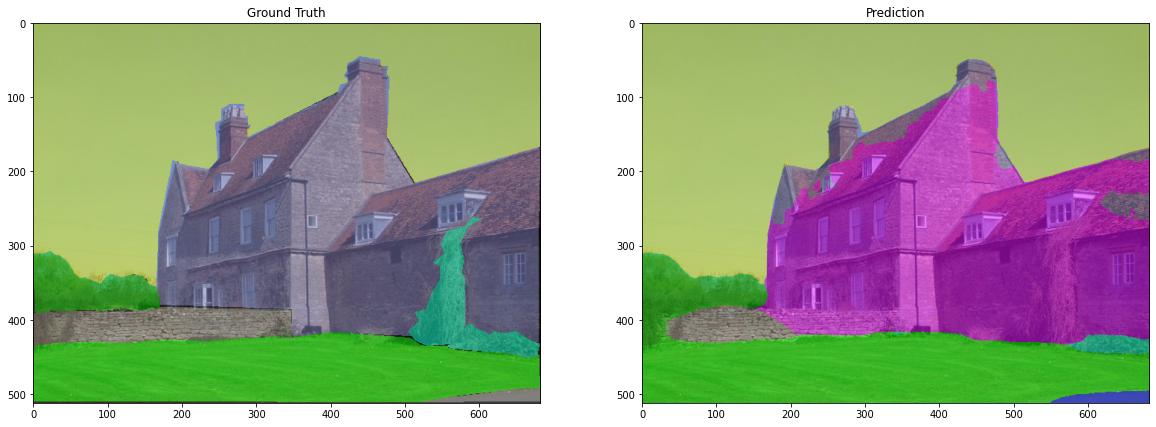

In [ ]:
fig = plt.figure(figsize=(20, 15))

ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(gtruth_img)
ax.set_title('Ground Truth')

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(pred_img)
ax.set_title('Prediction')
